In [9]:
################################
# Solves - u'' + u = f         #
# With zero Dirichlet boundary #
################################
import radiant as rad
import numpy as np


# Problem Parameters
a = 0.
b = 1.


def exact(*x):
    return np.prod(np.sin(np.asarray(x) * 2 * np.pi / (b - a)), axis=0)


def f(*x):
    return (len(x) * (2 * np.pi / (b - a)) ** 2 + 1) * exact(*x)


def g(*x):
    return np.zeros_like(x[0])

In [10]:
# Parameters
d = 1
k = 2
inner = 5
outer = 3
start_delta = 1.2
start_N = 101

# Computed Parameters
ranges = ((a, b),) * d
centre_thinning = 2 ** np.arange(inner)
delta_thinning = 2 ** np.arange(inner)
xcs = [rad.gridinc(ranges, inc, flat=True) for inc in (b - a) / (centre_thinning * (start_N - 1))]
deltas = start_delta / delta_thinning
bndry_eps = 1e-10
idx_funcs = [
    lambda cs: np.all([np.logical_and(np.abs(a - c) > bndry_eps, np.abs(b - c) > bndry_eps) for c in cs], axis=0),
    lambda cs: np.any([np.logical_or(np.abs(a - c) <= bndry_eps, np.abs(b - c) <= bndry_eps) for c in cs], axis=0),
]
operators = [
    lambda func: lambda *x: - func.laplacian(*x) + func(*x),
    lambda func: lambda *x: func(*x),
]

# Integration
error_integrator = rad.integrate.QuadIntegrator(ranges)

# Solve for approximate solution
solver = rad.solve.MultilevelSolver(d, k, deltas, xcs, outer, rad.solve.CollocationSolver, operators, idx_funcs)
approx = solver.solve(f, g)
error = rad.error(exact, approx, error_integrator)

print("L2 Relative Error:", error)
print("Condition Number:", solver.cond())

L2 Relative Error: 0.0036796972118418045
Condition Number: [128133.59468497013, 19650.924355389277, 793979.9213744154, 823088.5957177364, 87252456.53214651]


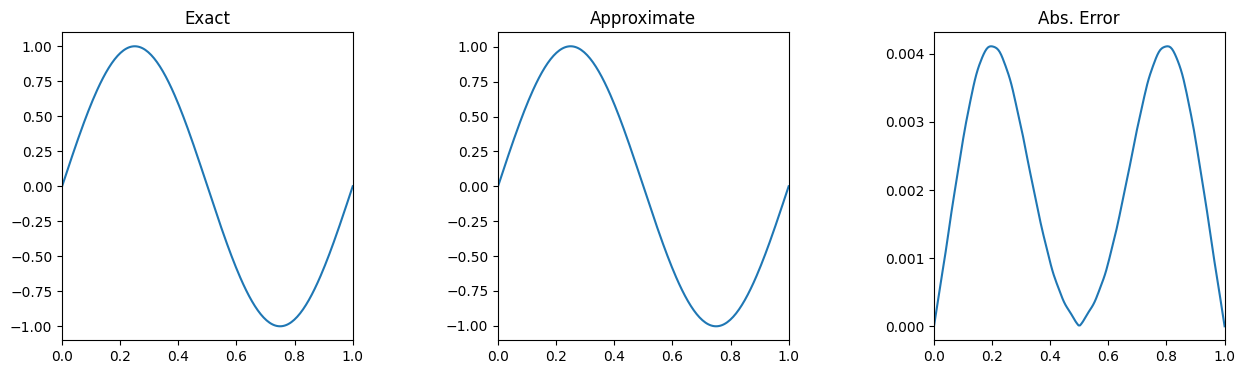

In [11]:
rad.plot.spread(
    ranges,
    exact,
    approx,
    lambda *x: np.abs(exact(*x) - approx(*x )),
    n=200,
    wspace=0.5,
    hspace=0.5,
    titles=["Exact", "Approximate", "Abs. Error"],
    figsize=(15, 4),
)

Once 
 
 Loop 
 
 Reflect

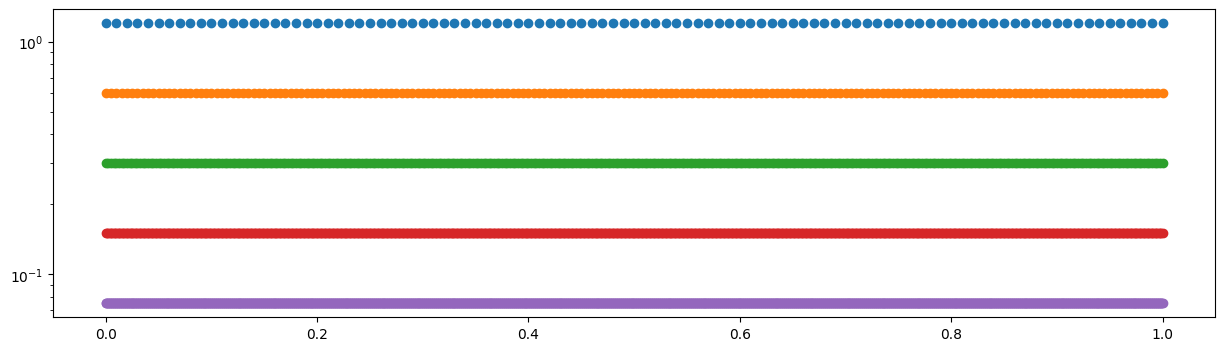

In [13]:
if d == 1:
    from IPython.display import HTML, display_html
    
    
    anim = rad.animate.ml_animate(ranges, exact, approx, n=200, figsize=(10, 4))
    display_html(HTML(anim.to_jshtml()))
    
    rad.plot.thinning(deltas, xcs, d, figsize=(15, 4))